In [2]:
using Pkg
Pkg.activate("/kuacc/users/ckorkmaz16/HiSD.jl/")

  Activating environment at `~/HiSD.jl/Project.toml`


In [3]:
run(`nvidia-smi`)

Sun Nov  7 23:52:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |      0MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Process(`nvidia-smi`, ProcessExited(0))

In [4]:
include("data.jl")
using .Data
include("transformations.jl")
using .Transformations
include("utils.jl")
using .Utils

In [5]:
using Images, Interpolations
using Images.FileIO
using Statistics
using Dates
using TensorBoardLogger, Logging, Random
using FileIO
using CUDA
using Knet

In [6]:
DATA_ROOT = "/kuacc/users/ckorkmaz16/HiSD_out"
CONFIG_FILE = "/kuacc/users/ckorkmaz16/HiSD.jl/configs/celeba-hq.yaml"

config = Utils.load_config(CONFIG_FILE)
println("Loaded config")

Loaded config


In [7]:
datasets = Utils.get_train_datasets(config, DATA_ROOT)
println("Loaded $(sum(length.(datasets))) datasets")
(x,y),i = iterate(datasets[1][1], 0)
size(x), size(y), i, typeof(x), typeof(y)

Loaded 7 datasets


((128, 128, 3, 8), (2, 8), 8, KnetArray{Float32, 4}, Knet.KnetArrays.KnetMatrix{Float32})

In [8]:
function show_image(x, i)
    xs = x[:,:,:,i:i]
    xs = permutedims(xs, [4, 3, 1, 2])
    image = reshape(xs, size(xs)[2:end]...)
    image = convert(Array, image)    
    image = image .* 0.5 .+ 0.5
    image = clamp.(image, 0.0, 1.0)
    image = image .|> N0f8 |> colorview(RGB)
    image 
end

show_image (generic function with 1 method)

In [72]:
module Network

using Knet
include("primitives.jl")
using .Primitives

export DownBlock
struct DownBlock; conv1; conv2; sc; activ; end
DownBlock(in_ch::Int,out_ch::Int) = 
    DownBlock(Conv(in_ch, in_ch, 3, 1), Conv(in_ch, out_ch, 3, 1), Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::DownBlock)(x)
    residual = avg_pool2d(d.sc(x), 2)
    out = d.conv2(d.activ(avg_pool2d(d.conv1(d.activ(x)), 2)))
    return (residual + out) / sqrt(2)  
end

export DownBlockIN
struct DownBlockIN; conv1; conv2; in1; in2; sc; activ; end
DownBlockIN(in_ch::Int,out_ch::Int) = 
    DownBlockIN(Conv(in_ch, in_ch, 3, 1), Conv(in_ch, out_ch, 3, 1), 
                InstanceNorm2d(in_ch), InstanceNorm2d(in_ch),
                Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::DownBlockIN)(x)
    residual = avg_pool2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.in2(avg_pool2d(d.conv1(d.activ(d.in1(x))), 2))))
    return (residual + out) / sqrt(2)  
end

export UpBlock
struct UpBlock; conv1; conv2; sc; activ; end
UpBlock(in_ch::Int,out_ch::Int) = 
    UpBlock(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::UpBlock)(x)
    residual = upsample2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.conv1(upsample2d(d.activ(x), 2))))
    return (residual + out) / sqrt(2)  
end

export UpBlockIN
struct UpBlockIN; conv1; conv2; in1; in2; sc; activ; end
UpBlockIN(in_ch::Int,out_ch::Int) = 
    UpBlockIN(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), 
              InstanceNorm2d(in_ch), InstanceNorm2d(out_ch),
              Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::UpBlockIN)(x)
    residual = upsample2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.in2(d.conv1(upsample2d(d.activ(d.in1(x)), 2)))))
    return (residual + out) / sqrt(2)  
end


export MiddleBlock, num_adain_params, assign_adain_params
struct MiddleBlock; conv1; conv2; adain1; adain2; sc; activ; end
MiddleBlock(in_ch::Int,out_ch::Int) = 
    MiddleBlock(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), 
                AdaptiveInstanceNorm2d(in_ch), AdaptiveInstanceNorm2d(out_ch),
                Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::MiddleBlock)(x)
    residual = d.sc(x)
    out = d.conv2(d.activ(d.adain2(d.conv1(d.activ(d.adain1(x))))))
    return (residual + out) / sqrt(2)  
end
Primitives.num_adain_params(d::MiddleBlock) = num_adain_params(d.adain1) + num_adain_params(d.adain2)
function Primitives.assign_adain_params(d::MiddleBlock, params)
    params = assign_adain_params(d.adain1, params)
    params = assign_adain_params(d.adain2, params)
    return params
end

export LinearBlock
struct LinearBlock; l; end
LinearBlock(in_dim::Int, out_dim::Int) = LinearBlock(Linear(in_dim, out_dim))
(l::LinearBlock)(x) = l(relu.(x))

struct Extractors; num_tags; model; end
function Extractors(config) 
    num_tags = length(config["tags"])
    channels = config["extractors"]["channels"]
    Extractors(num_tags, Chain(
            Conv(config["input_dim"], channels[1], 1, 0), 
            [DownBlock(channels[i], channels[i + 1]) for i in 1:(length(channels)-1)]...,
            AdaptiveAvgPool2d(1),
            Conv(channels[end],  config["style_dim"] * num_tags, 1, 0),
        )
    )
end
function (e::Extractors)(x, i)
    sty = e.model(x)
    sz = size(sty)
    sty = reshape(sty, (prod(sz) ÷ (e.num_tags * sz[end]), e.num_tags, sz[end]))
    return sty[:, i, :]
end

struct Mapper; pre_model; post_models; end
function Mapper(config, num_attributes)
    channels = config["mappers"]["pre_channels"]
    pre_model = Chain(
        Linear(config["noise_dim"], channels[1]),
        [LinearBlock(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...
    )
    channels = config["mappers"]["post_channels"]
    post_models = [
        Chain(
            [LinearBlock(channels[i], channels[i+1] for i in 1:(length(channels)-1)]...,
            Linear(channels[end], config["style_dim"])
        ) for i in 1:num_attributes
    ]
    Mapper(pre_model, post_models)
end
(m::Mapper)(z, j) = post_models[j](pre_model(z))


#TODO: Translator
#TODO: Generator, Discriminator

end

using .Network

        self.post_models = nn.ModuleList([nn.Sequential(
            *[LinearBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)],
            nn.Linear(channels[-1], hyperparameters['style_dim']), 
            ) for i in range(num_attributes)
        ])

    def forward(self, z, j):
        z = self.pre_model(z)
        return self.post_models[j](z)

In [51]:
config["extractors"]["channels"]

6-element Vector{Int64}:
   64
  128
  256
  512
 1024
 2048

In [73]:
Network.Extractors(config)

Main.Network.Extractors(3, Main.Network.Primitives.Chain((Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,3,64)), P(KnetArray{Float32, 4}(1,1,64,1)), 0, 1), Main.Network.DownBlock(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,64,64)), P(KnetArray{Float32, 4}(1,1,64,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,64,128)), P(KnetArray{Float32, 4}(1,1,128,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,64,128)), nothing, 0, 1), Main.Network.Primitives.LeakyRelu(0.2)), Main.Network.DownBlock(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,128,128)), P(KnetArray{Float32, 4}(1,1,128,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,128,256)), P(KnetArray{Float32, 4}(1,1,256,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,128,256)), nothing, 0, 1), Main.Network.Primitives.LeakyRelu(0.2)), Main.Network.DownBlock(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,256,256)), P(Kn

In [45]:
c = Network.Chain(
    Network.Conv(3, 64, 5, 2),
    Network.DownBlockIN(64, 128),
    Network.DownBlockIN(128, 256),
    Network.UpBlockIN(256, 128),
    Network.UpBlockIN(128, 64),
    Network.Conv(64, 3, 1, 0)
)

Main.Network.Primitives.Chain((Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(5,5,3,64)), P(KnetArray{Float32, 4}(1,1,64,1)), 2, 1), Main.Network.DownBlockIN(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,64,64)), P(KnetArray{Float32, 4}(1,1,64,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,64,128)), P(KnetArray{Float32, 4}(1,1,128,1)), 1, 1), Main.Network.Primitives.InstanceNorm2d(P(KnetArray{Float32, 3}(1,64,1)), P(KnetArray{Float32, 3}(1,64,1)), 64, 1.0e-5), Main.Network.Primitives.InstanceNorm2d(P(KnetArray{Float32, 3}(1,64,1)), P(KnetArray{Float32, 3}(1,64,1)), 64, 1.0e-5), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,64,128)), nothing, 0, 1), Main.Network.Primitives.LeakyRelu(0.2)), Main.Network.DownBlockIN(Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,128,128)), P(KnetArray{Float32, 4}(1,1,128,1)), 1, 1), Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(3,3,128,256)), P(KnetArray{Float32, 4}(1,1,256,1)), 1, 1), Mai

In [30]:
GC.gc(true)

In [46]:
l(x,y) = mean(abs2.(x-c(x)))
progress!(adam(l, Iterators.take(datasets[1][1], 1000)))

┣████████████████████┫ [100.00%, 1000/1000, 01:53/01:53, 8.85i/s] 


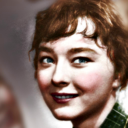

In [47]:
show_image(x, 1)

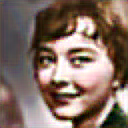

In [48]:
show_image(c(x), 1)

In [26]:
run(`nvidia-smi`)

Mon Nov  8 00:01:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |   5186MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Process(`nvidia-smi`, ProcessExited(0))